This is for the group analysis of the data.

In [1]:
from pprint import pprint

import glob
import matplotlib.pyplot as plt
import numpy as np
import os


In [7]:
from inout_utils import h5py_read

plot_test = True

root_path = '/home/wrx/Data_WF/WF_WRX/'

mice_id = 'Q38'
treat_saline = '20240826_saline'
treat_DOM = '20240826_DOM'

# mice_id = 'Q39'
# treat_saline = '20240829_saline'
# treat_DOM = '20240829_DOM'

path_saline = os.path.join(root_path, mice_id, treat_saline)
path_DOM = os.path.join(root_path, mice_id, treat_DOM)


Define functions

In [ ]:
def detect_threshold_crossing(data, thr):
    '''
    Detect the index of the 'data' array where the signal crosses a threshold of 'thr'
    data: np.array, one-dimensional
    thr: float
    return: index of the threshold crossings
    '''
    binary = (data > thr).astype(int)
    cross = np.diff(binary)
    index = np.where(cross == 1)[0]
    return index

Read the results

In [9]:
saline = h5py_read(os.path.join(path_saline, 'results.hdf5'))
print(saline.keys())
saline_st = saline['ST'] # spontaneous reuslt
print(saline_st.keys())

dom = h5py_read(os.path.join(path_DOM, 'results.hdf5'))
print(dom.keys())
dom_st = dom['ST'] # spontaneous reuslt
print(dom_st.keys())

saline_st_mean = saline_st['mean_values'] # frame mean of spontaneous activity
print(saline_st_mean.shape)
dom_st_mean = dom_st['mean_values'] # frame mean of spontaneous activity
print(dom_st_mean.shape)

# dom_st_velocity = dom_st['velocity']
# print(dom_st_velocity.shape)
# saline_st_velocity = saline_st['velocity']
# print(saline_st_velocity.shape)

dict_keys(['ST', 'params'])
dict_keys(['mean_values'])
dict_keys(['ST', 'params'])
dict_keys(['mean_values'])
(12005, 2)
(12060, 2)


(12005, 2)


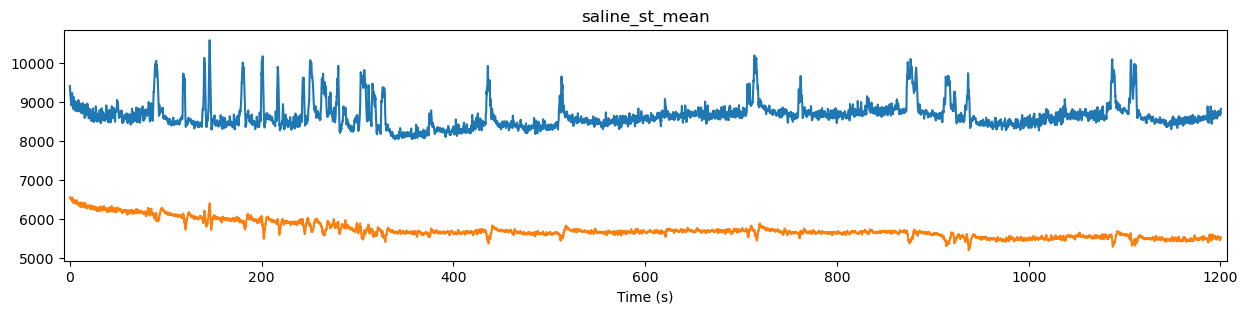

In [19]:
saline_st_mean = saline_st['mean_values'] # frame mean of spontaneous activity
print(saline_st_mean.shape)
plot_trace([saline_st_mean], title='saline_st_mean')

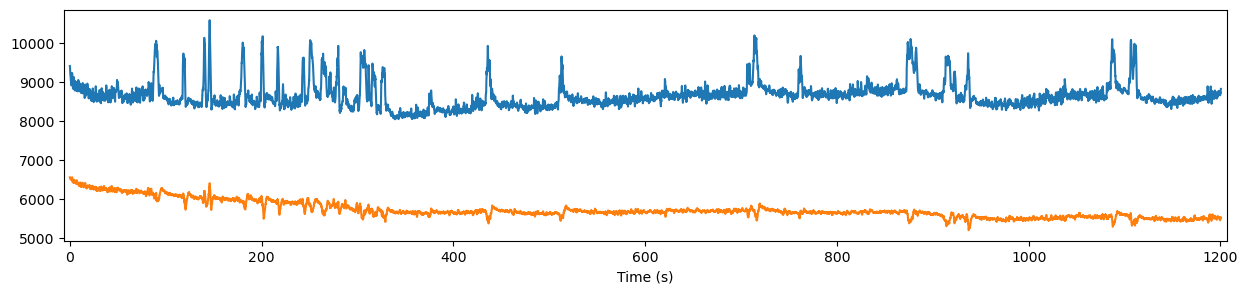

In [18]:
def plot_trace(data, figsize=(15, 3), title=None, interval=0.1):
    '''
    data: list
    interval: float, the interval between two samples, in seconds
    '''
    import matplotlib.pyplot as plt
    if type(data) != list:
        print('plot_trace: data should be a list')
        return

    fig, ax = plt.subplots(figsize=figsize)
    for i in range(len(data)):
        x = np.arange(len(data[i])) * interval
        ax.plot(x, data[i])
    ax.set_xlabel('Time (s)')
    
    precent = 0.005
    ax.set_xlim([-precent * x[-1], x[-1] * (1 + precent)])

    plt.title(title)
    plt.show()

plot_trace(list(saline_st_mean.T))

Cross-correlation

In [ ]:
def plot_two_row(data1, data2, figsize=(15, 5), xlim=None, title=None):
    '''
    data1: numpy.ndarray, the first dimension is samples, the second dimension is channels
    data2: 
    interval: float, the interval between two samples, in seconds
    xlim: tuple, the x-axis limit
    title: 
    '''
    import matplotlib.pyplot as plt
    fig, axis = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True, height_ratios=[2, 1], layout='tight')
    x = np.arange(data1.shape[0]) * 0.1
    axis[0].plot(x, data1)
    axis[0].set_ylabel('Fluorescence')

    x = np.arange(data2.shape[0]) * 0.1
    axis[1].plot(x, data2, color='r')
    axis[1].set_ylabel('Velocity (cm/s)')
    
    axis[1].set_xlabel('Time (s)')

    index = detect_threshold_crossing(abs(data2), 0.1)
    for i in index:
        axis[0].axvline(x=i*0.1, color='g', linestyle='--', linewidth=0.5)
        axis[1].axvline(x=i*0.1, color='g', linestyle='--', linewidth=0.5)

    if xlim is not None:
        axis[1].set_xlim(xlim)
    else:
        axis[1].set_xlim([0, data1.shape[0]*0.1])
    
    if title is not None:
        # axis[0].set_title(title[0])
        # axis[1].set_title(title[0])
        fig.suptitle(title)

    plt.subplots_adjust(hspace=0.05)
    plt.show()


In [ ]:
plot_two_row(saline_st_mean, saline_st_velocity, title='Saline')
plot_two_row(dom_st_mean, dom_st_velocity, title='DOM')

In [ ]:
from scipy import signal

data1 = dom_st_mean[:, 0] # saline_st_mean[:, 0], dom_st_mean[:, 0]

data2 = dom_st_velocity # saline_st_velocity, dom_st_velocity

# For testing the realationship between the two signals
# print(data1[0])
# data1 = np.roll(data1, 10)
# print(data1[10])

corr = signal.correlate(data1, abs(data2))
corr /= np.max(corr)
lags = signal.correlation_lags(len(data1), len(data2))


fig, ax = plt.subplots(figsize=(7, 3))

xlim = [-300, 300]
index_left = np.where(lags == xlim[0])[0][0]
index_right = np.where(lags == xlim[1])[0][0]

ax.plot(lags[index_left: index_right], corr[index_left: index_right])
ax.axvline(x=0, color='r', linestyle='--', linewidth=0.5)
_index = np.argmax(corr)
print('The lag is: ', lags[_index])
ax.axvline(x=lags[_index], color='g', linestyle='--', linewidth=0.5)

ax.set_xlabel('Lag')
plt.title('Cross-correlation between fluorescence and velocity of DOM')
plt.show()

STD comparison

Detrend traces first

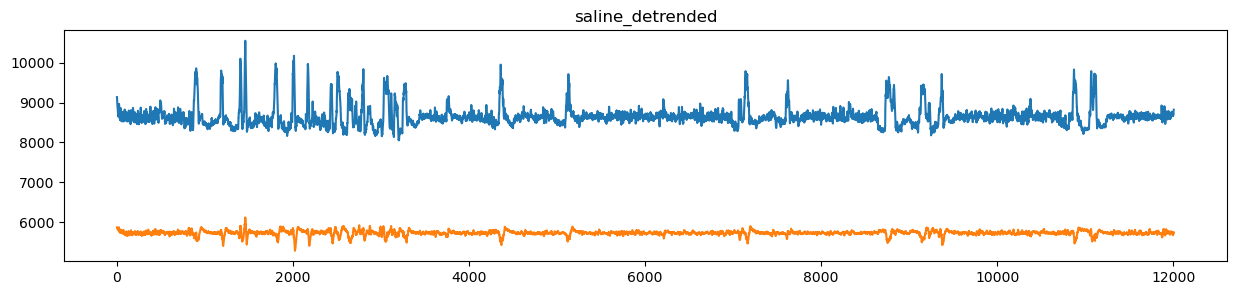

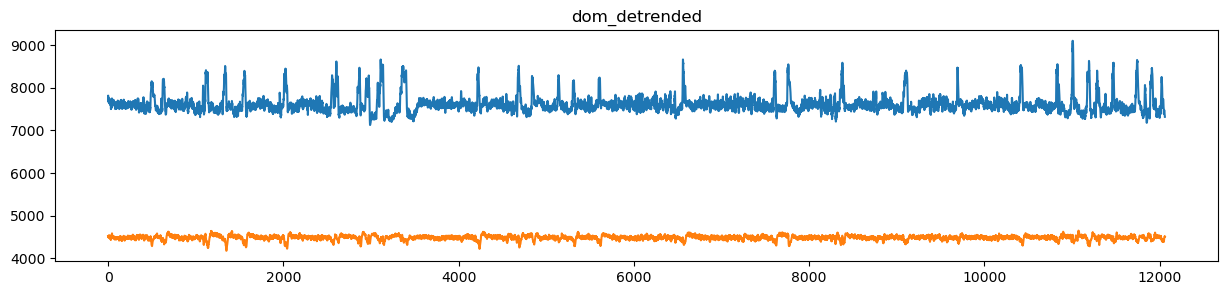

In [14]:
window = 300
saline_detrended = detrend(saline_st_mean, window=window)
dom_detrended = detrend(dom_st_mean, window=window)

if plot_test:
    plot_trace(list(saline_detrended.T), figsize=(15, 3), title='saline_detrended')
    plot_trace(list(dom_detrended.T), figsize=(15, 3), title='dom_detrended')

[256.20031092  59.19062279]
[211.27003108  52.14585427]


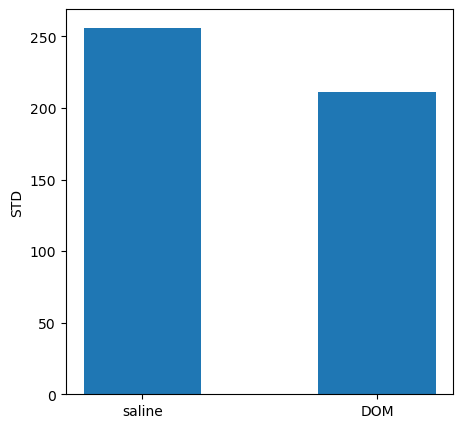

In [15]:
saline_st_mean_std = np.std(saline_detrended, axis=0)
print(saline_st_mean_std)
dom_st_mean_std = np.std(dom_detrended, axis=0)
print(dom_st_mean_std)

fig, ax = plt.subplots(figsize=(5, 5))
x = np.arange(2)
ax.bar(x, height=[saline_st_mean_std[0], dom_st_mean_std[0]], width=0.5)
plt.xticks(x, ['saline', 'DOM'])
plt.ylabel('STD')
plt.show()

Find the folders with specific name

In [ ]:
_path = os.path.join(path_ls[0], 'process', '*470-Values.csv')
print(_path)
# os.listdir(_path)
glob.glob(_path)

In [ ]:
root = '/home/wrx/Data_WF/WF_WRX/'

In [ ]:
mouse_id = '*'
expment_date = '*'
treatment = '*'
stimulus_name = '*Spontaneous'

In [ ]:
serach_path = os.path.join(root, mouse_id, '{}_{}'.format(expment_date, treatment), '*Spontaneous')

In [ ]:
path_ls = glob.glob(serach_path)
pprint(path_ls)